In [ ]:
### What it provides: block exon coordinates and numbers, Figure 1G
## Date_modified: 2025/04/16
## input: csv file with significantly altered dPSI values and gene_names (output script 1)
## output: several csv files with the coordinates of different block_exon categories (first, middle, last,
## exons in blocks that are more skipped or more included upon EIF4A3 depletion), Figure 1G plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
wh = pd.read_csv('sig_whip_CE_prob0.9_dPSI_0.1.csv')

# Count dPSI directions
negative_values_count = (wh['dPSI'] < 0).sum()
positive_values_count = (wh['dPSI'] > 0).sum()

print(f"There are {negative_values_count} exons more skipped upon eif4a3 depletion")
print(f"There are {positive_values_count} exons more included upon eif4a3 depletion")

There are 6579 exons more skipped upon eif4a3 depletion
There are 519 exons more included upon eif4a3 depletion


In [3]:
# Filter for Coordinated Exons (ΔPSI ≤ 0.02 within gene)

def find_coords_with_small_deltapsi_diff(group):
    result = []
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            if abs(group.iloc[i]['dPSI'] - group.iloc[j]['dPSI']) <= 0.02:
                result.extend([group.iloc[i]['Coord'], group.iloc[j]['Coord']])
    return result

coords_to_keep = (
    wh.groupby('gene_name')
    .apply(find_coords_with_small_deltapsi_diff)
    .explode()
    .dropna()
    .unique()
)

bl_ex = wh[wh['Coord'].isin(coords_to_keep)]


/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_75830/120507126.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wh.groupby('gene_name')


In [4]:
#  Subsample Coordinated Exons with Adjacent Neighbors
bl_ex_sorted = (
    bl_ex.groupby('gene_name')
    .apply(lambda x: x.sort_values('exon_number'))
    .reset_index(drop=True)
)

bl_ex_sorted['next_exon_diff'] = bl_ex_sorted.groupby('gene_name')['exon_number'].shift(-1) - bl_ex_sorted['exon_number']
bl_ex_sorted['prev_exon_diff'] = bl_ex_sorted['exon_number'] - bl_ex_sorted.groupby('gene_name')['exon_number'].shift(1)
bl_ex_sorted['has_neighbor'] = ((bl_ex_sorted['next_exon_diff'] == 1) | (bl_ex_sorted['prev_exon_diff'] == 1)).astype(int)

bl_ex_ad = bl_ex_sorted[bl_ex_sorted['has_neighbor'] == 1].reset_index(drop=True)

print(f"Mean of dPSI in block exons: {bl_ex_ad['dPSI'].mean():.3f}")
print(f"Median of dPSI in block exons: {bl_ex_ad['dPSI'].median():.3f}")

bl_ex_ad.to_csv("block_exons_ddPSImax0.2_adjacent.csv", index=False)


Mean of dPSI in block exons: -0.198
Median of dPSI in block exons: -0.170


/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_75830/2728816870.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bl_ex.groupby('gene_name')


In [5]:
#Define Blocks by ΔPSI Similarity and Characterize
proximity_threshold = 0.02

def create_subgroups(group):
    group = group.sort_values(by='dPSI').reset_index(drop=True)
    subgroups = []
    current_group = [group.iloc[0]]
    for i in range(1, len(group)):
        if abs(group.iloc[i]['dPSI'] - group.iloc[i - 1]['dPSI']) <= proximity_threshold:
            current_group.append(group.iloc[i])
        else:
            subgroups.append(current_group)
            current_group = [group.iloc[i]]
    subgroups.append(current_group)
    return subgroups

all_subgroups = bl_ex_ad.groupby('gene_name').apply(create_subgroups)

coord_counts_per_block = [len(block) for gene_blocks in all_subgroups for block in gene_blocks]
blocks_with_2plus = [count for count in coord_counts_per_block if count > 2]

print(f"Number of detected block exons: {len(bl_ex_ad)}")
print(f"Mean number of Coord per block: {np.mean(coord_counts_per_block):.2f}")
print(f"Percentage of blocks with >2 Coord: {100 * len(blocks_with_2plus) / len(coord_counts_per_block):.2f}%")


Number of detected block exons: 3105
Mean number of Coord per block: 2.41
Percentage of blocks with >2 Coord: 24.71%


/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_75830/4262726860.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_subgroups = bl_ex_ad.groupby('gene_name').apply(create_subgroups)


/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_75830/3584381130.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bl_ex.groupby('gene_name')


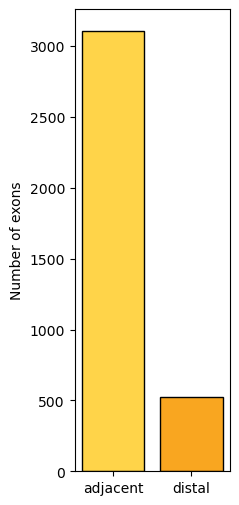

Percentage of exons with a direct neighbor: 85.51%


In [6]:
#Plot Adjacent vs Distal Coordinated Exons

# Recalculate neighbor status
plot_df = (
    bl_ex.groupby('gene_name')
    .apply(lambda x: x.sort_values('exon_number'))
    .reset_index(drop=True)
)

plot_df['next_exon_diff'] = plot_df.groupby('gene_name')['exon_number'].shift(-1) - plot_df['exon_number']
plot_df['prev_exon_diff'] = plot_df['exon_number'] - plot_df.groupby('gene_name')['exon_number'].shift(1)
plot_df['has_neighbor'] = ((plot_df['next_exon_diff'] == 1) | (plot_df['prev_exon_diff'] == 1)).astype(int)
plot_df['exon_category'] = plot_df['has_neighbor'].map({1: 'adjacent', 0: 'distal'})

# Plot
counts = plot_df['exon_category'].value_counts()
plt.figure(figsize=(2, 6))
plt.bar(counts.index, counts.values, color=['#FFD449', '#F9A620'], edgecolor='black')
plt.ylabel('Number of exons')
plt.savefig('bar_chart_corr_exons_adjacent.pdf')
plt.show()

print(f"Percentage of exons with a direct neighbor: {plot_df['has_neighbor'].mean() * 100:.2f}%")


In [7]:
#Break Down dPSI Direction and Save Subsets

positive_dpsi_df = bl_ex_ad[bl_ex_ad['dPSI'] > 0].reset_index(drop=True)
negative_dpsi_df = bl_ex_ad[bl_ex_ad['dPSI'] < 0].reset_index(drop=True)

positive_dpsi_df.to_csv("block_exons_ddPSImax0.2_adjacent.moreINCLUDED.csv", index=False)
negative_dpsi_df.to_csv("block_exons_ddPSImax0.2_adjacent.moreSKIPPED.csv", index=False)

or_exons = wh[~wh['Coord'].isin(bl_ex_ad['Coord'])]
or_exons.to_csv('single_regulated_exons.csv', index=False)


In [8]:
# Define First, Last, Middle Exons in Each Block

def get_terminal_exons(df, first=True):
    results = []
    for gene, group in df.groupby('gene_name'):
        group = group.sort_values('exon_number').reset_index(drop=True)
        group['group_id'] = (group['dPSI'].diff().abs() > 0.2).cumsum()
        for group_id, sub_group in group.groupby('group_id'):
            exon_idx = sub_group['exon_number'].idxmin() if first else sub_group['exon_number'].idxmax()
            exon = sub_group.loc[exon_idx]
            results.append({'gene_name': gene, 'group_id': group_id, 'Coord': exon['Coord'], 'exon_number': exon['exon_number']})
    return pd.DataFrame(results)

first_exons = get_terminal_exons(bl_ex_ad, first=True)
last_exons = get_terminal_exons(bl_ex_ad, first=False)

# Save them
first_exon_incl = positive_dpsi_df[positive_dpsi_df['Coord'].isin(first_exons['Coord'])].reset_index(drop=True)
first_exon_skip = negative_dpsi_df[negative_dpsi_df['Coord'].isin(first_exons['Coord'])].reset_index(drop=True)
last_exon_incl = positive_dpsi_df[positive_dpsi_df['Coord'].isin(last_exons['Coord'])].reset_index(drop=True)
last_exon_skip = negative_dpsi_df[negative_dpsi_df['Coord'].isin(last_exons['Coord'])].reset_index(drop=True)

first_exon_incl.to_csv("first_block_exon.moreINCLUDED.csv", index=False)
first_exon_skip.to_csv("first_block_exon.moreSKIPPED.csv", index=False)
last_exon_incl.to_csv("last_block_exon.moreINCLUDED.csv", index=False)
last_exon_skip.to_csv("last_block_exon.moreSKIPPED.csv", index=False)

# Define middle exons
middle_exon_incl = positive_dpsi_df[~positive_dpsi_df['Coord'].isin(pd.concat([first_exon_incl, last_exon_incl])['Coord'])].reset_index(drop=True)
middle_exon_skip = negative_dpsi_df[~negative_dpsi_df['Coord'].isin(pd.concat([first_exon_skip, last_exon_skip])['Coord'])].reset_index(drop=True)

middle_exon_incl.to_csv("middle_block_exon.moreINCLUDED.csv", index=False)
middle_exon_skip.to_csv("middle_block_exon.moreSKIPPED.csv", index=False)
